In [1]:
import os 
import zipfile 

import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torchvision
import torchvision.transforms as transforms

import glob
from PIL import Image

from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from IPython.display import clear_output
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
import seaborn as sns

from keras import backend as K

from sklearn.utils import resample

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
data_dir = "images/"
metadata_path = "HAM10000_metadata.csv"

In [3]:
#Lesion Dictionary
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
# Read metadata into dataframe
metadata = pd.read_csv(metadata_path)
skin_df = metadata

In [5]:
# Dictionary for Image Names
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob.glob(os.path.join(data_dir, '*.jpg'))}

In [6]:
#Create useful Columns - Images Path, Lesion Type and Lesion Categorical Code
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [7]:
# Lesion code dictionary
lesion_code_dict = pd.Series(skin_df.dx.values,index=skin_df.cell_type_idx).to_dict()

lesion_code_dict

{2: 'bkl', 4: 'nv', 3: 'df', 5: 'mel', 6: 'vasc', 1: 'bcc', 0: 'akiec'}

In [8]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,images\ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,images\ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,images\ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,images\ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,images\ISIC_0031633.jpg,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,images\ISIC_0033084.jpg,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,images\ISIC_0033550.jpg,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,images\ISIC_0033536.jpg,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,images\ISIC_0032854.jpg,Actinic keratoses,0


In [9]:
# Attach images to the skin_df Dataframe
temp_arr, count = [], 0
for path in tqdm(skin_df['path']):
  temp_arr.append(np.asarray( Image.open(path).resize((100,75)) ))
  count += 1
  # print(f"Processed images: {count}")
  # if count % 10 == 0: clear_output()

skin_df['image'] = temp_arr


# skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10015/10015 [11:41<00:00, 14.28it/s]


In [10]:
# Create a backup of the created skin_df

backup_skin_df = skin_df

In [11]:
# Checkpoint. Start From Here

skin_df = backup_skin_df

In [43]:
# WARNING: CHANGES THE ORIGINAL DATASET ABOVE
# RUN ONLY WHEN YOU REQUIRE TO IMPLEMENT OVERSAMPLING FOR CLASS IMBALANCE!
# Under sampling
final_samples = 500

temp_nv_df = skin_df.loc[skin_df['cell_type_idx'] == 4]
temp_nv_df = temp_nv_df.sample(n=final_samples, replace=False, random_state=15)
print(temp_nv_df.shape)
print(skin_df.shape)
skin_df = skin_df[skin_df['cell_type_idx'] != 4]
print(skin_df.shape)
skin_df = pd.concat([skin_df, temp_nv_df])
print(skin_df.shape)

(500, 12)
(10015, 12)
(3310, 12)
(3810, 12)


In [11]:
# WARNING: CHANGES THE ORIGINAL DATASET ABOVE
# RUN ONLY WHEN YOU REQUIRE TO IMPLEMENT OVERSAMPLING FOR CLASS IMBALANCE!
# Over sampling
additional_samples = 4000
new_skin_df = skin_df.loc[skin_df['cell_type_idx'] == 4]

count = 0
for i in range(0, 7):
    if i == 4: continue
    print(f'For class: {i}')
    
    temp_class_df = skin_df.loc[skin_df['cell_type_idx'] == i]
    print(temp_class_df.shape)
    temp_class_df_oversampled = temp_class_df.sample(n=len(temp_class_df)+additional_samples, replace=True, random_state=15)
    print(temp_class_df_oversampled.shape)
    count += temp_class_df_oversampled.shape[0]
    
    new_skin_df = pd.concat([new_skin_df, temp_class_df_oversampled])

skin_df = new_skin_df
print(f'Final skin_df shape: {skin_df.shape}')
print(count)

For class: 0
(327, 12)
(4327, 12)
For class: 1
(514, 12)
(4514, 12)
For class: 2
(1099, 12)
(5099, 12)
For class: 3
(115, 12)
(4115, 12)
For class: 5
(1113, 12)
(5113, 12)
For class: 6
(142, 12)
(4142, 12)
Final skin_df shape: (34015, 12)
27310


In [12]:
# Separate the dataframe into Features and Targets data
features = skin_df.drop(columns=['cell_type_idx','dx'],axis=1)
target = skin_df['cell_type_idx']

In [28]:
# Create First Train and Test sets
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20, random_state=1)

In [29]:
# Create image arrays from the train and test sets
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

In [30]:
# Class distribution before data augmentation
train_value_counts = y_train_o.value_counts()
print(train_value_counts)
print(f'Total images: {train_value_counts.sum()}')

4    5378
5     891
2     871
1     418
0     266
6     110
3      78
Name: cell_type_idx, dtype: int64
Total images: 8012


In [142]:
# Under sampling

# Prepare x_train
x_train_nv_indices = y_train_o.reset_index(drop=True).index[y_train_o == 4]
print(x_train_nv_indices.shape)
x_train_nv = x_train[x_train_nv_indices]
print(x_train_nv.shape)

nv_downsampled = resample(x_train_nv,
                            replace = False, # sample without replacement
                            n_samples = 1000, # match minority n
                            random_state = 27) # reproducible results

print(nv_downsampled.shape)
x_train_wo_nv = np.delete(x_train,x_train_nv_indices, axis=0)
# print(x_train_wo_nv)
print(x_train_wo_nv.shape)

new_x_train = np.concatenate((nv_downsampled, x_train_wo_nv))
print(new_x_train.shape)

# Prepare y_train
y_train_nv_indices = y_train_o.index[y_train_o == 4]
y_train_o_wo_nv = y_train_o.drop(y_train_nv_indices)
print(y_train_o_wo_nv.shape)
new_y_train_o = y_train_o_wo_nv.append(pd.Series([4 for i in range(0, 1000)]))
print(new_y_train_o.shape)

x_train = new_x_train
y_train_o = new_y_train_o

(5378,)
(5378, 75, 100, 3)
(1000, 75, 100, 3)
(2634, 75, 100, 3)
(3634, 75, 100, 3)
(2634,)
(3634,)


In [175]:
# Data Augmentation
# Image data generator is used to generate the possible versions of data as given below.

dataaugment = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10
    ) 

8012


In [168]:
# Perform the data augmentation.
# Store the result in a directory as well as the training images and classes arrays.

# For each lesion code != 4, get the indices in y_train_o.
# For the same indices in x_train_o, augment the image present in the row.
reset_y_train_o = y_train_o.reset_index(drop=True)
reset_index = reset_y_train_o.index

print(len(y_train_o))

for i in tqdm(range(0, 7)):
    if i == 4: continue
    print(f'class = {i}')
    
    indices = reset_index[reset_y_train_o == i]
    image_series = x_train_o.iloc[0]['image']
    
    images_array = np.asarray(image_series.tolist())
    images_array = images_array.reshape(images_array.shape[0], *(75, 100, 3))
    
    img_count, batch_count = 0, 0
    for batch in dataaugment.flow(images_array, batch_size=500, save_to_dir='aug/', save_prefix='aug'):
        img_count += len(batch)
        batch_count += 1
        
        print(f'Batch {batch_count} size: {len(batch)} :: total images generated: {img_count}')
        
        # x_train = np.append(x_train, batch)
        x_train = np.concatenate((x_train, batch), axis=0)
        print(f'Appended to x_train: {len(batch)} :: x_train.shape : {x_train.shape} ')
        
        temp_series = pd.Series([i for j in range(0, len(batch))])
        y_train_o = y_train_o.append(temp_series, ignore_index=True)
        print(f'Appended to y_train_o: {len(temp_series)}')
        
        if img_count > 3000: break

  0%|                                                                                                                                                                                      | 0/7 [00:00<?, ?it/s]

class = 0


ValueError: cannot reshape array of size 22500 into shape (75,75,100,3)

In [48]:
print(len(x_train))

3048


In [49]:
# Class distribution after handling class imbalance
train_value_counts = y_train_o.value_counts()
print(train_value_counts)
print(f'Total images: {train_value_counts.sum()}')

5    902
2    863
1    412
4    406
0    264
6    115
3     86
Name: cell_type_idx, dtype: int64
Total images: 3048


In [31]:
print(x_train[0][0])

[[199 142 149]
 [198 143 148]
 [201 144 153]
 [202 145 153]
 [203 145 150]
 [204 145 152]
 [204 143 151]
 [206 145 153]
 [206 148 164]
 [208 150 166]
 [212 153 165]
 [211 150 164]
 [214 152 170]
 [215 153 168]
 [211 151 166]
 [212 151 166]
 [212 149 166]
 [211 151 164]
 [209 148 158]
 [211 148 165]
 [210 148 165]
 [210 149 167]
 [210 148 162]
 [211 149 160]
 [214 154 170]
 [215 156 171]
 [216 154 169]
 [212 150 160]
 [213 152 165]
 [214 153 162]
 [212 152 162]
 [214 151 161]
 [214 152 164]
 [217 155 168]
 [216 156 164]
 [216 156 165]
 [216 157 167]
 [217 156 167]
 [216 153 168]
 [214 152 163]
 [215 154 168]
 [215 153 166]
 [213 152 165]
 [214 153 167]
 [214 154 169]
 [214 153 169]
 [213 150 166]
 [213 150 165]
 [213 149 163]
 [209 145 153]
 [210 150 160]
 [212 151 162]
 [212 151 164]
 [210 148 157]
 [208 145 156]
 [209 146 158]
 [209 144 158]
 [208 148 163]
 [209 151 165]
 [209 149 163]
 [210 150 163]
 [209 150 164]
 [209 147 160]
 [206 148 162]
 [210 150 164]
 [208 150 164]
 [206 148 

In [23]:
# The normalisation is done using the training set Mean and Std. Deviation as reference
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

In [27]:

print(x_train[0][0])

[[ 0.84198702 -0.38498166 -0.23430129]
 [ 0.82046125 -0.36345589 -0.25582706]
 [ 0.88503855 -0.34193012 -0.14819823]
 [ 0.90656432 -0.32040436 -0.14819823]
 [ 0.92809009 -0.32040436 -0.21277553]
 [ 0.94961585 -0.32040436 -0.16972399]
 [ 0.94961585 -0.36345589 -0.19124976]
 [ 0.99266738 -0.32040436 -0.14819823]
 [ 0.99266738 -0.25582706  0.0885852 ]
 [ 1.03571892 -0.21277553  0.13163673]
 [ 1.12182198 -0.14819823  0.11011097]
 [ 1.10029622 -0.21277553  0.0885852 ]
 [ 1.16487352 -0.16972399  0.2177398 ]
 [ 1.18639928 -0.14819823  0.17468827]
 [ 1.10029622 -0.19124976  0.13163673]
 [ 1.12182198 -0.19124976  0.13163673]
 [ 1.12182198 -0.23430129  0.13163673]
 [ 1.10029622 -0.19124976  0.0885852 ]
 [ 1.05724468 -0.25582706 -0.0405694 ]
 [ 1.10029622 -0.25582706  0.11011097]
 [ 1.07877045 -0.25582706  0.11011097]
 [ 1.07877045 -0.23430129  0.1531625 ]
 [ 1.07877045 -0.25582706  0.04553367]
 [ 1.10029622 -0.23430129  0.00248214]
 [ 1.16487352 -0.12667246  0.2177398 ]
 [ 1.18639928 -0.08362093

In [51]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [52]:
# Splitting training into Train and Validatation sets
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state=1)

# Reshaping the Images into 3 channels (RGB)
# height = 75, width = 100, canal = 3
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [53]:
# New Baseline CNN

input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 25, 64)       

In [54]:
# Define metrics 

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [55]:
# New baseline
# Define the optimizer
optimizer = Adam(learning_rate=0.001, 
                 beta_1=0.9, 
                 beta_2=0.999, 
                 # epsilon=None, 
                 decay=0.0, 
                 amsgrad=False)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy", f1_m,precision_m, recall_m])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [56]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_validate = np.asarray(x_validate)
y_validate = np.asarray(y_validate)

In [57]:
# New baseline
# Fit the model
epochs = 30
batch_size = 10
# history = model.fit_generator(dataaugment.flow(x_train,y_train, batch_size=batch_size),
#                               epochs = epochs, validation_data = (x_validate,y_validate),
#                               verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
#                               , callbacks=[learning_rate_reduction])

history = model.fit(x=x_train, y=y_train,
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
274/274 [==============================] - 64s 219ms/step - loss: 1.6765 - accuracy: 0.3453 - f1_m: 0.1443 - precision_m: 0.4107 - recall_m: 0.0934 - val_loss: 1.3627 - val_accuracy: 0.4918 - val_f1_m: 0.2470 - val_precision_m: 0.8967 - val_recall_m: 0.1461
Epoch 2/30
274/274 [==============================] - 62s 227ms/step - loss: 1.4619 - accuracy: 0.4333 - f1_m: 0.2404 - precision_m: 0.5972 - recall_m: 0.1608 - val_loss: 1.3504 - val_accuracy: 0.4754 - val_f1_m: 0.3990 - val_precision_m: 0.6251 - val_recall_m: 0.2950
Epoch 3/30
274/274 [==============================] - 61s 222ms/step - loss: 1.3843 - accuracy: 0.4615 - f1_m: 0.2876 - precision_m: 0.6011 - recall_m: 0.2010 - val_loss: 1.2551 - val_accuracy: 0.4951 - val_f1_m: 0.4080 - val_precision_m: 0.7591 - val_recall_m: 0.2818
Epoch 4/30
274/274 [==============================] - 62s 226ms/step - loss: 1.3083 - accuracy: 0.4918 - f1_m: 0.3576 - precision_m: 0.6315 - recall_m: 0.2611 - val_loss: 1.1417 - val_accuracy:

dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m', 'lr'])
Accuracy: 0.9533632397651672
loss: 0.1328534185886383
f1_m: 0.9548803567886353
precision_m: 0.9622101783752441
recall_m: 0.9483062624931335


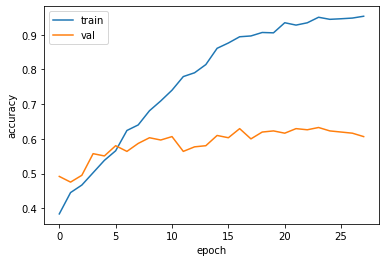

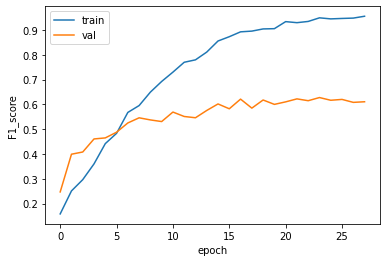

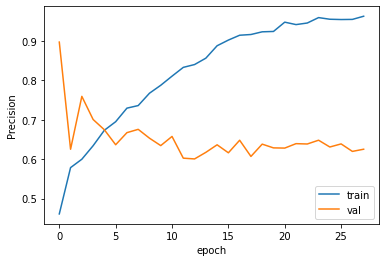

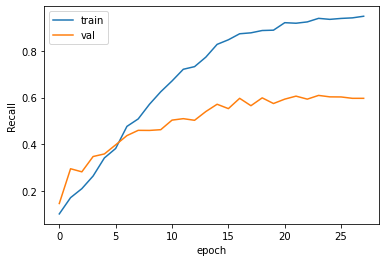

In [58]:
# plot graphs from history
print(history.history.keys())
print(f'Accuracy: {history.history["accuracy"][-1]}')
print(f'loss: {history.history["loss"][-1]}')
print(f'f1_m: {history.history["f1_m"][-1]}')
print(f'precision_m: {history.history["precision_m"][-1]}')
print(f'recall_m: {history.history["recall_m"][-1]}')

plt.plot(history.history["accuracy"], label='accuracy')
plt.plot(history.history["val_accuracy"], label='Validaion accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history["f1_m"], label='F1_score')
plt.plot(history.history["val_f1_m"], label='Validaion F1_score')
plt.ylabel('F1_score')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history["precision_m"], label='Precision')
plt.plot(history.history["val_precision_m"], label='Validaion Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history["recall_m"], label='Recall')
plt.plot(history.history["val_recall_m"], label='Validaion Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [28]:
# Evaluate model
test_eval = model.evaluate(x_test, y_test, verbose=1, return_dict=True)
validation_eval = model.evaluate(x_validate, y_validate, verbose=1, return_dict=True)
# model.save("model.h5")

86/86 [==============================] - 13s 146ms/step - loss: 0.1037 - accuracy: 0.9732 - f1_m: 0.9736 - precision_m: 0.9749 - recall_m: 0.9724


In [29]:
for i, j in validation_eval.items():
    print(f'{i}: {j}')

loss: 0.1037459671497345
accuracy: 0.9731814861297607
f1_m: 0.9736060500144958
precision_m: 0.9748914241790771
recall_m: 0.9723837375640869


In [30]:
for i, j in test_eval.items():
    print(f'{i}: {j}')

loss: 0.13353893160820007
accuracy: 0.9726591110229492
f1_m: 0.9725062251091003
precision_m: 0.9739606976509094
recall_m: 0.9710974097251892


In [189]:
# Get predictions for plotting the confusion matrix
predictions = model.predict(x_test, verbose=1)

63/63 [==============================] - 9s 141ms/step


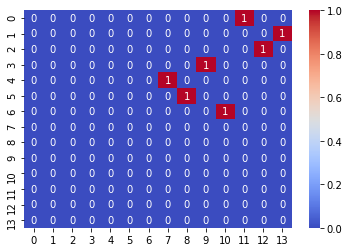

In [190]:
# Plot the confusion matrix
predictions = np.argmax(predictions, axis=0)
y_test = np.argmax(y_test, axis=0)

sns.heatmap(confusion_matrix(y_test, predictions), annot=True, cmap = 'coolwarm', fmt='.0f')
plt.show()

In [ ]:
# New Baseline CNN 2

input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(128, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.1))
model.add(Dense(500))

model.add(Conv2D(128, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Dense(250))

model.add(Conv2D(128, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(num_classes, activation='softmax'))
model.summary()


In [91]:
# Old Baseline CNN

# After considering one input and one output per tensor
# Initializing CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64, (3,3), padding='Same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(64,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(64,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(64,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes, activation='softmax'))

# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

#Output
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))